# Read in the data

In [14]:
import pandas as pd
import numpy
import re

data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv',
]
data = {}

for f in data_files:
    key_name = f.replace('.csv', '')
    d = pd.read_csv(f'schools/{f}')
    data[key_name] = d

# Read in the surveys

In [15]:
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey = survey.copy()
survey['DBN'] = survey['dbn']

survey_fields = [
    'DBN',
    'rr_s',
    'rr_t',
    'rr_p',
    'N_s',
    'N_t',
    'N_p',
    'saf_p_11',
    'com_p_11',
    'eng_p_11',
    'aca_p_11',
    'saf_t_11',
    'com_t_11',
    'eng_t_11',
    'aca_t_11',
    'saf_s_11',
    'com_s_11',
    'eng_s_11',
    'aca_s_11',
    'saf_tot_11',
    'com_tot_11',
    'eng_tot_11',
    'aca_tot_11',
]
survey = survey[survey_fields]
data['survey'] = survey

# Add DBN columns

In [16]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']


def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return '0' + string_representation


data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

# Convert columns to numeric

In [17]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

data['sat_results']['sat_score'] = (
    data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
)


def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lat = coords[0].split(',')[0].replace('(', '')
    return lat


def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc)
    lon = coords[0].split(',')[1].replace(')', '').strip()
    return lon


data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

<>:11: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\('
<>:11: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\('
/var/folders/hn/8p1b_k2127zf_kp_238tglf00000gn/T/ipykernel_21053/1145006712.py:11: SyntaxWarning: invalid escape sequence '\('
  coords = re.findall('\(.+, .+\)', loc)
/var/folders/hn/8p1b_k2127zf_kp_238tglf00000gn/T/ipykernel_21053/1145006712.py:17: SyntaxWarning: invalid escape sequence '\('
  coords = re.findall('\(.+, .+\)', loc)


# Condense datasets

In [18]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

class_size = class_size.groupby('DBN').agg('mean', numeric_only=True)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

# Convert AP scores to numeric

In [19]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

# Combine the datasets

In [20]:
combined = data['sat_results']

combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.infer_objects(copy=False).fillna(0)

# Add a school district column for mapping

In [21]:
def get_first_two_chars(dbn):
    return dbn[0:2]


combined = combined.copy()
combined['school_dist'] = combined['DBN'].apply(get_first_two_chars)

# Find correlations

In [22]:
correlations = combined.corr(numeric_only=True)
correlations = correlations['sat_score']
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [23]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove('DBN')

# Survey Fields vs SAT Score

In [24]:
sat_corr = {}

for s in survey_fields:
    sat_corr[s] = combined['sat_score'].corr(combined[s])

print(sat_corr)

{'rr_s': np.float64(0.23219912927511957), 'rr_t': np.float64(-0.023386291173466373), 'rr_p': np.float64(0.04792451883198435), 'N_s': np.float64(0.4234629475091972), 'N_t': np.float64(0.2914630275178503), 'N_p': np.float64(0.4215300253580893), 'saf_p_11': np.float64(0.12291283627180785), 'com_p_11': np.float64(-0.11507348242782603), 'eng_p_11': np.float64(0.020254107222305903), 'aca_p_11': np.float64(0.035154618008655755), 'saf_t_11': np.float64(0.3138103333520103), 'com_t_11': np.float64(0.08241941890129452), 'eng_t_11': np.float64(0.03690647858376121), 'aca_t_11': np.float64(0.1323476677825646), 'saf_s_11': np.float64(0.33763874436088137), 'com_s_11': np.float64(0.18737020184780123), 'eng_s_11': np.float64(0.2138216081347262), 'aca_s_11': np.float64(0.33943547354225356), 'saf_tot_11': np.float64(0.3187534502170987), 'com_tot_11': np.float64(0.07731020128970857), 'eng_tot_11': np.float64(0.10010182962480557), 'aca_tot_11': np.float64(0.1909659779409331)}


In [25]:
sat_corr_df = pd.DataFrame.from_dict(sat_corr, orient='index')

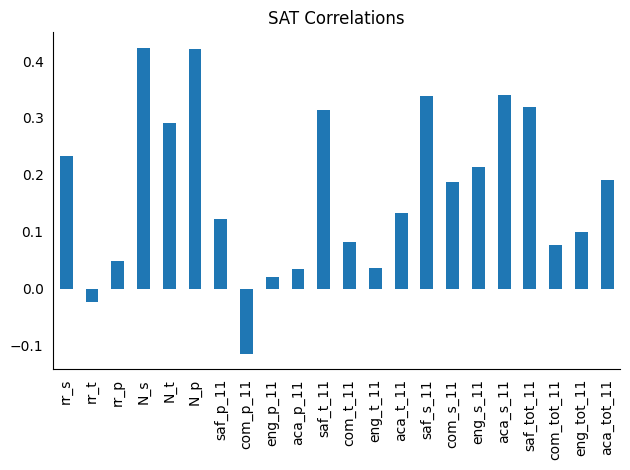

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sat_corr_df.plot.bar(legend=False)
plt.title('SAT Correlations')
plt.tick_params(left=False, bottom=False)

plt.tight_layout()
sns.despine()

plt.savefig('visualizations/sat_corr.png')
plt.show()

## Interesting Correlations:
- `N_s`: Number of student respondents (~0.4)
- `N_t`: Number of teacher respondents (~0.3)
- `N_p`: Number of parent respondents (~0.4)
- `saf_t_11`: Safety and Respect score based on teacher responses (~0.3)
- `saf_s_11`: Safety and Respect score based on student responses (~0.3)
- `aca_s_11`: Academic expectations score based on student responses (~0.3)
- `saf_tot_11`: Safety and Respect total score (~0.3)

# Investigate Safety Scores

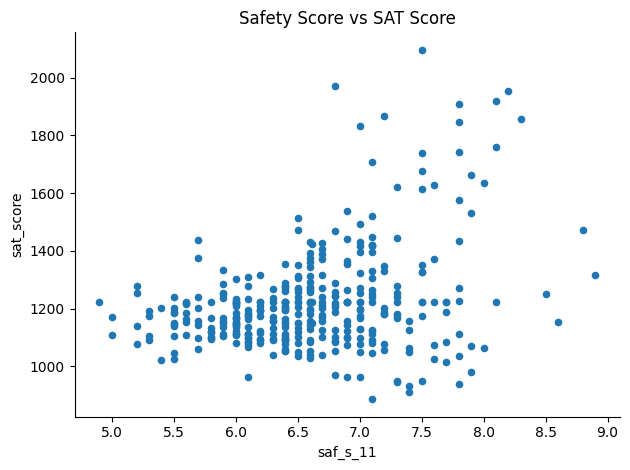

In [29]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

plt.title('Safety Score vs SAT Score')

plt.tight_layout()
sns.despine()

plt.savefig('visualizations/safety_vs_sat.png')
plt.show()

## Conclusions Drawn:
- There is a slightly positive correlation in which safer schools achieve higher SAT scores